## Mercari Price Suggestion

### Import statements

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

import timeit

In [6]:
PATH='data/'
!ls {PATH}

models	sample_submission.csv  test.tsv  tmp  train.tsv


In [7]:
train = pd.read_csv(f'{PATH}/train.tsv', sep='\t')
test_df = pd.read_csv(f'{PATH}/test.tsv', sep='\t')

In [8]:
display(train.head(2))
display(test_df.head(2))

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."


In [9]:
def join_columns(df):
    # casting into string converts NaN to nan
    ret = '<category> ' + df.category_name.astype(str).str.replace(r'[\s*]','').str.replace(r'/',' ') 
    ret += ' <name> ' + df.name.astype(str) + ' <description> ' + df.item_description.astype(str)
    return ret

train['item_description'] = join_columns(train)
test_df['item_description'] = join_columns(test_df)

In [10]:
train['item_description'].iloc[0]

'<category> Men Tops T-shirts <name> MLB Cincinnati Reds T Shirt Size XL <description> No description yet'

In [11]:
ntrn = len(train)
ntrn

1482535

In [12]:
# since test size is 500K pick a comparable val size
val_idx = train.sample(int(ntrn*0.35)).index
(val_df, train_df),  = split_by_idx(val_idx, train)

In [13]:
len(val_df)/ntrn

0.3499998313699171

In [14]:
import time

class time_check:
    def __init__(self):
        type(self).current = time.time()
        type(self).last = None
    
    @staticmethod
    def showtime(str1):
        time_check.last = time_check.current
        time_check.current = time.time()
        print(str1, time_check.current-time_check.last)
        sys.stdout.flush()
        return 

## Tokenization

In [15]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
re_ptbl = re.compile(f'([{string.printable}])')
re_rm = re.compile(r'\s*\[\s*rm\s*\]\s*')
re_num = re.compile(r'([0-9])')

In [16]:
import collections
all_des = val_df['category_name'].str.cat(sep=' ')
chars = list(all_des)
counter=collections.Counter(chars)
ret = str('')
for x in counter: ret += x[0]
ret

"Home/ DécrAntsWJwlyNkaSp&OudGiBMT,CEPhg-VFbKf(4+)RLvZq'02U5Ixz1Y7Q"

In [14]:
import collections
all_des = val_df['item_description'].str.cat(sep=' ')
chars = list(all_des)
counter=collections.Counter(chars)
ret = str('')
for x in counter: ret += x[0]
ret

'<category> WmnOhBudlisqfRpb,CkwzAL.S&GNPTVDIvH9"MFx0251[]K:\'’E-%U6JX3j*48!#Y/(+)é\xa0Q~@7⋅☆?Z;➡♡❌•❤️❗☺✨⬆⭐=⬅|‼▪⚡¼$…®è·✔⃣\\×Ó‘✖\u200b{}➕\u2028ô●\u3000［］＊❣©™–☀”Ⓜ_✳✅¤♦♥°⚠☘“■çÁá✴√ＦＡＱ^É¡℉★◆Σ￣□˘³\u2029⏺—ë：✭☃❎⚫➖。・✘✂》℃≥í，▶）⬛✉❇❄�÷ñ✧ツ†！ᖴᗩᑕᗪᔕᒪᑭᗯᖇ⛔⭕″、（《◾½☄✈⁄◀☞☜¾⬇☑♨ó⚜\xad♠ē〰☻⁉α£Ē‑➰¥€✽♢❁▫\x97ً➔ÍᏚᎢᎬᎡᏞᏩᏙᏌᎾᎠᏔᏢ↪↩`✓\x7f◕‿╹◡⊙︿û＼／❀à⋆ғᴇʟʀᴛᴏᴀᴋɴʏǫᴜɪᴍʜᴠᴘʙᴄᴅɢᴡッ◼◇¿ōÑᑎᐯ︎❥ꕥΩ❓【】ξ»ᴢ⤵✕►⠀☐⇻◈ú☇Û❊͈ᴗ☒⚘Ü↗«ℹø✮∆Π⚪⏩⏪☹화양연⛅❕➽äいなばぁっこんにちはたらラタンワとゃ日本の中古品ですオリジナルケース付きませう傷があり自宅再生機視聴可能しよろくお願↘ö♻̈ᎪᎷᏴᎻ☯☮⚛☪¯˜☾↓¢✩⛱îİÈ⚽✌ā┅✿⏬\u200eü≤✦¹⛄→²ᐠᐛᐟ♧♪♬ᗰ№◦ı↖↙◑ØÄÇ◉✏；▼ì⚀\ufeffÔ〽º☠⛳☝ÀÌ☼⏳⚅↔✯✄ʕᴥʔ☁≫♤￼Δ✗３⛵⇢⇠⇝⇜⇨⇦Ꮯ➵ķ\u2006±➺＝＄\x16☕ʼ대한민국\x96♀゜※✪❃☽♍☂⅞Õ⤴○\uf8ff➜✬вєуσυℓѕâ♣\uf04a⅛ūï\x92ღ？⚃✼℅〃⛤\x03\u2002я⊝ᴊ\uf8b8\uf81e\uf8bc\uf821\uf820\uf824\uf8e7ꪹꪵ\uf823\uf8ea☡אודםхｗｉｌｄｆｏｘ˚ω∙～͜͡ʖêᴖθ♛ᏃᏆ◻═⛥₂⚂͟カネボウソアイシャドⅠ✚\x94̑⏰\u202f➝➳け玉剣拳❈←ÂÒę᙭ᕼÎ⇾Æ⌚―ビトフォマサヒパダ´\x99ãļ∅ⓟⓔⓣⓢⓜⓞⓚⓕⓡź♏⏹Ë⅔−༶﹏мιтнĸЅΙ⚾ᑌꂦノヮ♫⌊⌉⚓¨å↟‡≧▽≦ăßŸŠㅡćù⇉⇇✺❦．ᕕᕗĹ✱⁰\x1aﬂﬁŁšś↠↕✷⊹\u2009õᵔª△⚁\u200fò➪➣⇒▵방탄션단앵무새죽이기우리들의행복시간정가원묶음으로구입하면송비를절약실수있습니다彡✍⊗ꍏ┌ಠ┘Úϟ소년＋刚化玻璃片č◯⚄⇣ч\uf84c˝ᗷ✫⌛\x14❉◔ⓛⓦ⛓Ū〜ゝ∂ł㎡⬘☙⚝ổ╮╯╰╭ミ⁃\u202dΦ➲☔♐ď'

In [17]:
# to skip computation
ret = """HmDéAnsLhSudipNw.Rlf[]bTqkFJW24KGOC&7Yz/x!)B-~:v✨“”,1MEVX50\'6PI3U8%(+9"\xa0Q@*#;Z➡♡j•❤️\u3000?［］＊–è’|$⚡▪❄…®✴{}\\❇=☑Ó‼☆♥_⬇❗⛔♦°⭐¡^üë❣✭íÁ½✳×✅❌—☺✔➖《》¤″⚠⬆➕■☇◇●▶➔！✉☀✖á★✧ツ†〰\u200b€¥É©™\u2028ñシ、（），：‘ú❎☄ô◀ᏢᎡᏟᏞᎬᎪᎢᏌᏚᏆ·♨⚜⃣▼�√«»\xad⁉α£︎❥♏✈▫⬅ē❓å➺Õ¼☞✽♢○âÜÍᏩᏙᎾᎠᏔç♧◡̈⭕ō⚫ᔕᖇᒪᑎᐯᖴᗩᗯ‑Ⓜ☼⤵↪Ω`⇻◈①②③❀\u2029⏺\x7fΚΑθ⋆ғʀᴇʜɪᴘʟᴛᴏᴀᴋɴʏǫᴜᴍᴠʙᴄᴅɢᴡッ¾ℹ◕‿╹⊙︿⏩⏪✝□℃ä✏いなばぁっこんにちはたらラタンワとゃ日本の中古品です。オリジナルケース付きませう傷があり自宅再生機視聴可能しよろくお願ᎷᏴᎻ❁⇝↓⛵【】◑┅♠\u200eĒ→☻´∀｀・Ñ♻Ô⏰óØᐠᐛᐟ❕⛥¹ᑕᗰ◉ı↖↘↙；ᕼᗷᑌᗪ✓∆ì►⚘ºʕᴥʔà✌ω～✦➾➳⚀✩ꕥ✿ß❃☾☽⚾È▵ÄÇ⚅◆█✯û♛≥≤Ⓡ♤ᴢ◾◼乛Öū⟁➜☡✲゜͡ᵔ͜ʖ☕✂³⚪čï※➰\x96\x16ᴊ↔÷ă✪˘¦îê◠✬Β✘語⁄Ìღ✮？＆☐ø⛤☝\uf8e7ꪹꪵ\uf81e\uf823\uf8eaℓєя⊝◦☃❊⠀ö²―⌚Σ￣\uf8ff➙⚓Ꮓ↩¿☯☮⚛☪\ufeff͈ᴗ☒⅜〽ⓡⓔⓓⓑⓛⓐⓒⓚⓦⓗⓘⓣⓢⓤⓝ§Δξェヽノ✕➝∅ⓟⓜⓞⓕ☜↟◄⇒Â═☔❶❷❸❹❺❻،¶Æ˚⛅ﬁ\x99♪⇢⋅¢༶⛄☠＼／ʘ＄☸⚃「」☹➀➁⛳‡ËŸŠ℅⅛ㅡ⟹❦☁Ûś『』šù✷⊹õã⺣\u202f⬛İ⏹Ⓢⓨ±⚁￼⅔✄ŕ▿ò➪⁰ā୨୧\x95∙̀\u2009♫⛱❔ᑭ➵☘⇨⇦➲\uf84c△♀℉˝✼さ冊¯ọ✫Ð↕\uf8ba\uf8bc\uf8b8\uf8bd\uf8b9\uf8c0⌛国结刺绣小紫色的心形丝绸挂件Ū\x14⁴♣⛓〜ゝ∂㎡᙭′どかも森絵ポトビ他╮╯╰╭Φ\x92➿⏬招猫一"""

In [18]:
spcl = re_ptbl.sub(r'', ret)
re_spcl = re.compile(f'([{spcl}0-9])')

In [19]:
from spacy.symbols import ORTH

my_tok = spacy.load('en')

# To join multiple columns
# my_tok.tokenizer.add_special_case('<SUMM>', [{ORTH: '<SUMM>'}])
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])
my_tok.tokenizer.add_special_case('<category>', [{ORTH: '<category>'}])
my_tok.tokenizer.add_special_case('<name>', [{ORTH: '<name>'}])
my_tok.tokenizer.add_special_case('<description>', [{ORTH: '<description>'}])
my_tok.tokenizer.add_special_case('[rm]', [{ORTH: '[rm]'}])

def my_spacy_tok(x):
    x = str(x).lower()
    # x = re.sub(r'[^\x00-\x7f]', r' ', x)
    x = re_rm.sub(' [rm] ', x)
    #x = re_num.sub(r' \1 ', x)
    x = re_spcl.sub(r' \1 ', x)
    x = ' '.join(x.split())
    return [tok.text for tok in my_tok.tokenizer(x)]

In [20]:
my_spacy_tok("a123.【】 ♥")

['a', '1', '2', '3', '.', '【', '】', '♥']

## Language Model for category, name and item_description 

In [21]:
# Use small portion for text modeling 
sample = 0.2
train_text = train_df.sample(int(sample*len(train_df))).reset_index()
val_text = val_df.sample(int(sample*len(val_df))).reset_index()

(array([   1135.,   56803.,  111234.,  172722.,  100045.,  138350.,   83271.,  109401.,   63493.,   81542.,
          46619.,   61350.,   35199.,   45828.,   27106.,   36000.,   21148.,   27510.,   16214.,   21298.,
        ...,     162.,      88.,     200.,      82.,      47.,      96.,     101.,      32.,      79.,
             24.,       8.,       1.,       2.,       0.,       1.,       0.,       1.,       1.,       1.,
              1.]),
 array([   6.  ,    8.52,   11.04,   13.56,   16.08,   18.6 ,   21.12,   23.64,   26.16,   28.68,   31.2 ,
          33.72,   36.24,   38.76,   41.28,   43.8 ,   46.32,   48.84,   51.36,   53.88, ...,  210.12,  212.64,
         215.16,  217.68,  220.2 ,  222.72,  225.24,  227.76,  230.28,  232.8 ,  235.32,  237.84,  240.36,
         242.88,  245.4 ,  247.92,  250.44,  252.96,  255.48,  258.  ]),
 <a list of 100 Patch objects>)

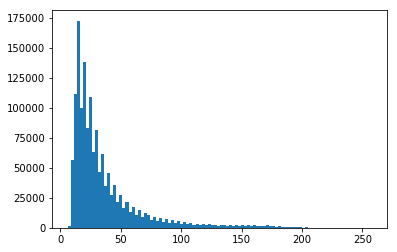

In [33]:
text_length = train['item_description'].apply(lambda x: len(str(x).split()))
plt.hist(text_length, bins=100)

In [22]:
# This is to test if numericalization is possible with the given text with symbols and all special characters
# Since the origibal text can be lengthy 

t = time_check()
def test_text_dataload(field, df, col):
    # fir create Fields
    fields = [('text', field)]
    text = []
    
    # Tokenize
    text += field.preprocess(df[col].str.cat(sep=' <eos> '))
    text.append('<eos>')
    # create datasets
    examples = [torchtext.data.Example.fromlist([text], fields)]
    dataset = torchtext.data.Dataset(examples, fields)
    
    field.build_vocab(dataset)
    
    t.showtime("build examples and vocab:")
    flush
    # create dataloader from dataset this is one long text 
    text = sum([o.text for o in dataset], [])
    n=100
    for i in np.arange(int(len(text)/n)):
        if (i%10000 == 0):
            t.showtime(str(i)+" numericalize :")
            flush
        itext = [text[i*n:(i+1)*n]]
        try: 
            nums = field.numericalize(itext)
        except (RuntimeError):
            print(itext)
    return 

#TEXT = data.Field(lower=True, tokenize=my_spacy_tok)
#test_text_dataload(TEXT, train_text, 'item_description')

In [23]:
ITEM_DESCRIPTION = data.Field(lower=True, tokenize=my_spacy_tok)

Possible text processings:
0. min_freq, bs, bptt 
1. highlight for a streak of caps
2. replace " -" word with `<list>`
3. plural handling (?)
4. handling past/present/future tense


In [24]:
bs,bptt = 128,50
min_freq=10
tag="match_trn_val"

In [25]:
# DF takes 12mins on GTX1060
idmd = LanguageModelData.from_dataframes(PATH, ITEM_DESCRIPTION, 'item_description', train_text, val_text, val_text, 
                                       bs=bs, bptt=bptt, min_freq=min_freq)
pickle.dump(ITEM_DESCRIPTION, open(f'{PATH}models/ITEM_DESCRIPTION_{tag}.pkl','wb'))

In [26]:
idxs = ITEM_DESCRIPTION.numericalize([['♥', 'xyz']])
idxs = idxs.data.cpu().numpy().ravel()
#ITEM_DESCRIPTION.vocab.itos[idx.data.cpu().numpy()[0]]
#idx.data.cpu().numpy()
[(idx,ITEM_DESCRIPTION.vocab.itos[idx]) for idx in idxs]

[(1908, '♥'), (0, '<unk>')]

#### Unfderstanding Input/Output

In [27]:
' || '.join(ITEM_DESCRIPTION.vocab.itos[:12])

'<unk> || <pad> || . || , || <category> || <description> || <eos> || <name> || ! || and || 1 || women'

In [28]:
len(ITEM_DESCRIPTION.vocab.itos[:])

15343

In [29]:
len(idmd.trn_dl), idmd.nt, len(idmd.trn_ds), len(idmd.trn_ds[0].text)

(1355, 15343, 1, 8680264)

In [30]:
'   '.join(idmd.trn_ds[0].text[:50])

"<category>   beauty   haircare   shampoo&conditionersets   <name>   holding   wen   2   bottle   over   1   2   oz/   bottle   <description>   holding   for   sdrzsg   4   0   wen   six   thirteen   by   chaz   dean   ,   ultra   nourishing   cleansing   treatment   for   hair   .   it   's   a   lemon   rosemary   vanilla   bean   scent   <eos>   <category>   beauty   makeup   makeuppalettes   <name>   bnib   le"

In [31]:
to_np(ITEM_DESCRIPTION.numericalize([idmd.trn_ds[0].text[:50]])).ravel()

array([    4,    45,   922,  2897,     7,  2453,  4957,    13,   445,   335,    10,    13,  2599,   445,
           5,  2453,    15,     0,    26,    18,  4957,  2360, 11741,   152, 10587,  6591,     3,   763,
        4554,  1824,  1445,    15,   308,     2,    36,    39,    16,  2095,  5771,  1251,  2511,   873,
           6,     4,    45,    64,   421,     7,  1989,  2919])

In [32]:
batch = next(iter(idmd.trn_dl))
xs, y = batch
print("Xs={}\nYs={}".format(xs, y))

Xs=Variable containing:
     4   2292   1342  ...    1779   2638     29
    45   1043    725  ...     950   4990   5544
   922      7      5  ...       5   3913    602
        ...            ⋱           ...         
  1251    784     10  ...       3   1940     17
  2511     34      3  ...    3402    413     32
   873     16   4166  ...       7      5     43
[torch.cuda.LongTensor of size 42x128 (GPU 0)]

Ys=Variable containing:
    45
  1043
   725
  ⋮   
  4264
  8242
     6
[torch.cuda.LongTensor of size 5376 (GPU 0)]



### TEXT Model Learner
##### Tune these learning parameters

In [33]:
em_sz = 100  # size of each embedding vector
nh = 200     # number of hidden activations per layer
nl = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [34]:
id_learner = idmd.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)

In [35]:
id_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
id_learner.clip=0.3

#### Unfderstanding Input/Output of the Edcoder-Decoder Model

In [36]:
ntrn

1482535

In [37]:
lm = id_learner.model
lm

SequentialRNN (
  (0): RNN_Encoder (
    (encoder): Embedding(15343, 100, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout (
      (embed): Embedding(15343, 100, padding_idx=1)
    )
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(100, 200, dropout=0.05)
      )
      (1): WeightDrop (
        (module): LSTM(200, 200, dropout=0.05)
      )
      (2): WeightDrop (
        (module): LSTM(200, 100, dropout=0.05)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouths): ModuleList (
      (0): LockedDropout (
      )
      (1): LockedDropout (
      )
      (2): LockedDropout (
      )
    )
  )
  (1): LinearDecoder (
    (decoder): Linear (100 -> 15343)
    (dropout): LockedDropout (
    )
  )
)

In [38]:
# Test 1 batch 
lm.reset()   # Initializes hidden states
rnn_enc, lin_dec = lm
raw_outputs, outputs = rnn_enc(*[xs])
lstm1_op, lstm2_op, lstm3_op = outputs
lstm3_op

Variable containing:
( 0 ,.,.) = 
 -4.4758e-02  7.4585e-03  1.8314e-02  ...  -3.1149e-02  1.8176e-02 -2.2777e-03
 -4.6178e-02  6.3326e-03  1.8344e-02  ...  -3.1044e-02  1.7707e-02 -3.4300e-03
 -4.6265e-02  7.4348e-03  1.6810e-02  ...  -3.0746e-02  1.9027e-02 -2.6596e-03
                 ...                   ⋱                   ...                
 -4.4694e-02  7.6293e-03  1.7821e-02  ...  -2.9771e-02  1.7545e-02 -1.6881e-03
 -4.5830e-02  7.5543e-03  1.9599e-02  ...  -2.9679e-02  1.7508e-02 -2.0004e-03
 -4.4141e-02  8.0052e-03  1.7165e-02  ...  -2.9648e-02  1.7769e-02 -2.1913e-03

( 1 ,.,.) = 
 -6.7363e-02  4.6915e-03  2.2757e-02  ...  -4.4870e-02  2.9250e-02 -1.9758e-03
 -7.0571e-02  3.1861e-03  2.2255e-02  ...  -4.4802e-02  2.8535e-02 -3.8281e-03
 -7.0108e-02  4.5743e-03  1.9771e-02  ...  -4.4483e-02  3.0747e-02 -2.6667e-03
                 ...                   ⋱                   ...                
 -6.7709e-02  5.0739e-03  2.1648e-02  ...  -4.2043e-02  2.7853e-02 -6.7811e-04
 -6.

In [39]:
word_map, raw_outputs, outputs = lin_dec([raw_outputs, outputs])
word_map

Variable containing:
 3.4898e-03  8.3568e-03  7.3704e-03  ...   2.5602e-02  2.1766e-03  7.7881e-03
 6.2540e-04  9.5010e-03  7.6554e-04  ...   2.2584e-02 -1.2874e-03  8.7497e-03
 7.1270e-03  1.0459e-02  1.5013e-03  ...   1.7077e-02 -2.6456e-03  4.7618e-03
                ...                   ⋱                   ...                
-3.0950e-03  2.2168e-02 -1.1662e-03  ...   4.6552e-02 -2.1737e-03  1.7574e-02
 2.9055e-03  1.6324e-02  9.7078e-03  ...   4.2519e-02  4.3329e-03  1.7457e-02
-8.6456e-03  2.9341e-03  1.1887e-02  ...   3.2033e-02  6.2839e-03  1.0625e-02
[torch.cuda.FloatTensor of size 5376x15343 (GPU 0)]

In [37]:
id_learner.lr_find()

A Jupyter Widget

 92%|█████████▏| 1376/1496 [01:31<00:08, 14.97it/s, loss=19.1]

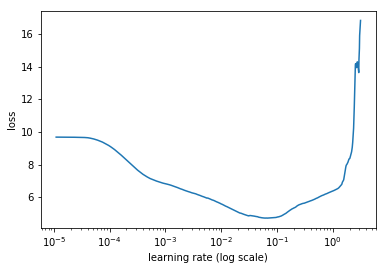

In [38]:
id_learner.sched.plot()

In [40]:
id_learner.fit(2.0e-2, 2, wds=1e-6, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       4.59451  4.49359]                                  
[ 1.       4.04386  3.92221]                                  
[ 2.       3.8661   3.72083]                                  
[ 3.       3.77331  3.65912]                                  



In [40]:
#del(id_learner)

In [41]:
id_learner.save_encoder(f'adam1_enc_{tag}')

# Process DataFrames and Create Data Loaders

In [257]:
def split_into_columns(x, split_by="/", ncol=4, fillna='NA'):
    l = str(x).split(split_by)
    return pd.Series((l+fillna*(ncol-len(l)))[:ncol])

In [42]:
test_df.head(2)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,<category> Women Jewelry Rings <name> Breast c...
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,<category> Other Officesupplies ShippingSuppli...


In [43]:
text_name = 'item_description'
text_vars = [text_name]
cat_vars = ['item_condition_id', 'category_name', 'brand_name', 'shipping']
contin_vars = []
dep = 'price'
cols = text_vars+cat_vars+contin_vars+[dep]

In [44]:
train_df2 = train[text_vars+cat_vars+contin_vars+[dep]].copy()
test_df[dep] = 0.0
test_df2 = test_df[text_vars+cat_vars+contin_vars+[dep, 'test_id']].copy()

Before we call torch text to create DataLoaders we need to convert categorical data to numerical data. 

In [45]:
# make train/test categories
for v in cat_vars: train_df2[v] = train_df2[v].astype('category').cat.as_ordered()
apply_cats(test_df2, train_df2)

In [46]:
cat_sz = [(c, len(train_df2[c].cat.categories)+1) for c in cat_vars]
cat_emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [47]:
# make float continuous variables if any
for v in contin_vars+[dep]:
    train_df2[v] = train_df2[v].astype('float32')
    test_df2[v] = test_df2[v].astype('float32')

In [48]:
# numericalize all but the text field then add it back at the end
# pd.get_dummies creates expanded 1 hot encoding then collapsed
df, y, nas = proc_df(train_df2, dep, skip_flds=text_vars, do_scale=False)
df[text_vars] = train_df2[text_vars].astype(str)
df[dep] = np.log(y+1)

In [49]:
df.dtypes

item_condition_id       int8
category_name          int16
brand_name             int16
shipping                int8
item_description      object
price                float32
dtype: object

In [50]:
df_test, _, nas = proc_df(test_df2, dep, do_scale=False, 
                          skip_flds=text_vars + ['test_id'], na_dict=nas)
df_test[text_vars] = test_df2[text_vars].astype(str)
df_test[dep] = 0.0

In [51]:
display(df.head(2))
df_test.head(2)

,item_condition_id,category_name,brand_name,shipping,item_description,price
0,3,809,0,2,<category> Men Tops T-shirts <name> MLB Cincin...,2.397895
1,3,87,3558,1,<category> Electronics Computers&Tablets Compo...,3.970292


,item_condition_id,category_name,brand_name,shipping,item_description,price
0,1,1183,0,2,<category> Women Jewelry Rings <name> Breast c...,0.0
1,1,878,0,2,<category> Other Officesupplies ShippingSuppli...,0.0


#### call torch.text to process the text in text field and create data splits

In [103]:
ITEM_DESCRIPTION = pickle.load(open(f'{PATH}models/ITEM_DESCRIPTION_{tag}.pkl','rb'))
# test my_spacy_token
my_spacy_tok(df['item_description'].iloc[0])

['<category>',
 'men',
 'tops',
 't',
 '-',
 'shirts',
 '<name>',
 'mlb',
 'cincinnati',
 'reds',
 't',
 'shirt',
 'size',
 'xl',
 '<description>',
 'no',
 'description',
 'yet']

In [104]:
DATA_FIELDS = {'item_description': ITEM_DESCRIPTION}
for v in cat_vars: 
    DATA_FIELDS[v] = data.Field(sequential=False, use_vocab=False)
DATA_FIELDS[dep] = data.Field(sequential=False, tensor_type=torch.FloatTensor, use_vocab=False)

In [105]:
n=2000000
dfs = {'test': df_test.iloc[:min(n, len(df_test))]}
(dfs['val'], dfs['train']),  = split_by_idx(val_idx, df)
dfs['val'] = dfs['val'].iloc[:min(n, len(dfs['val']))]
dfs['train'] = dfs['train'].iloc[:min(n, len(dfs['train']))]

len(dfs['train'])

963648

In [106]:
min_freq=10

In [107]:
# tokenize and cast to object type prior to creating examples to save time
dtypes = {}
for split_type in ['train', 'val', 'test']:
    t = time_check()
    tbl = dfs[split_type]
    tbl.loc[:,text_name] = tbl[text_name].apply(DATA_FIELDS[text_name].tokenize)
    t.showtime(split_type+" tokenize :")

train tokenize : 282.36514472961426
val tokenize : 145.18840861320496
test tokenize : 305.5603578090668


In [61]:
??data.Example

In [99]:
dfs['train']['item_description'].iloc[0]

['<category>',
 'men',
 'tops',
 't',
 '-',
 'shirts',
 '<name>',
 'mlb',
 'cincinnati',
 'reds',
 't',
 'shirt',
 'size',
 'xl',
 '<description>',
 'no',
 'description',
 'yet']

In [108]:
class MixedTextDataset(torchtext.data.Dataset):
    def __init__(self, split_type, text_name, data_fields, dfs, **kwargs):
        #type(self).text_name = text_name
        fields = list(data_fields.items())
        cols = [fld[0] for fld in fields]
        #cols.remove(text_name)
        df = dfs[split_type]
        
        t = time_check()
        # populating examples using fromList is slow 
        #examples = list(df.apply(lambda x: data.Example.fromlist(list(x[cols]), fields), axis=1))
        n = len(df) 
        examples = []
        for i in range(n):
            ex = data.Example()
            for col in cols:
                setattr(ex, col, df[col].iloc[i])
                #print(col, type(getattr(examples[i], col)))
            examples.append(ex)
        
        t.showtime(split_type+" creation of examples "+str(n)+" :")
        super().__init__(examples, fields, **kwargs)
        t.showtime(split_type+" dataset done "+str(n)+" :")

    @staticmethod
    def sort_key(ex): return len(ex.item_description)
    
    @classmethod
    def splits(cls, data_fields, train, val, test, dfs, **kwargs):
        # set path to null ('') as we are dealing with dataframes
        return super().splits('', data_fields=data_fields,  
                              train=train, validation=val, test=test, dfs=dfs, **kwargs)

In [109]:
# No GPU, so optimize
splits = MixedTextDataset.splits(DATA_FIELDS, text_name='item_description', train='train', 
                                     val='val', test='test', dfs=dfs)

train creation of examples 963648 : 54.90806579589844
train dataset done 963648 : 0.0006690025329589844
val creation of examples 518887 : 32.61764216423035
val dataset done 518887 : 0.0015587806701660156
test creation of examples 693359 : 44.055135011672974
test dataset done 693359 : 0.0005402565002441406


In [110]:
# Fields contain vocab, examples contain data 
for i in range(5):
    for var in df.columns:
        val = getattr(splits[0].examples[i], var)
        print(var, " : ", type(val), " : ", val)

item_condition_id  :  <class 'numpy.int8'>  :  3
category_name  :  <class 'numpy.int16'>  :  809
brand_name  :  <class 'numpy.int16'>  :  0
shipping  :  <class 'numpy.int8'>  :  2
item_description  :  <class 'list'>  :  ['<category>', 'men', 'tops', 't', '-', 'shirts', '<name>', 'mlb', 'cincinnati', 'reds', 't', 'shirt', 'size', 'xl', '<description>', 'no', 'description', 'yet']
price  :  <class 'numpy.float32'>  :  2.3979
item_condition_id  :  <class 'numpy.int8'>  :  3
category_name  :  <class 'numpy.int16'>  :  87
brand_name  :  <class 'numpy.int16'>  :  3558
shipping  :  <class 'numpy.int8'>  :  1
item_description  :  <class 'list'>  :  ['<category>', 'electronics', 'computers&tablets', 'components&parts', '<name>', 'razer', 'blackwidow', 'chroma', 'keyboard', '<description>', 'this', 'keyboard', 'is', 'in', 'great', 'condition', 'and', 'works', 'like', 'it', 'came', 'out', 'of', 'the', 'box', '.', 'all', 'of', 'the', 'ports', 'are', 'tested', 'and', 'work', 'perfectly', '.', 'the'

In [122]:
class MixedTextDataLoader():
    def __init__(self, src, x_fld, c_flds, y_fld):
        self.src,self.x_fld,self.c_flds, self.y_fld = src,x_fld,c_flds, y_fld

    def __len__(self): return len(self.src)-1

    def __iter__(self):
        it = iter(self.src)
        for i in range(len(self)):
            b = next(it)
            # work-around: core.py does not handle list of lists for V and VV
            ys = getattr(b, self.y_fld)
            bs_it = len(ys)
            cat_batch = torch.cat([getattr(b, f).view(bs_it, 1) for f in self.c_flds], 1)
            yield getattr(b, self.x_fld), cat_batch, ys


class MixedTextModel(BasicModel):
    def get_layer_groups(self):
        # defines how the differential learning rates would be applied to model groups
        m=self.model
        m_enc = m.rnn_encoder
        return [m_enc.encoder, *zip(m_enc.rnns, m_enc.dropouths), (children(m.lins)+children(m.bns)+[m.outp])]

class MixedTextData(ModelData):
    def create_td(self, it): return TextDataLoader(it, self.text_fld, self.label_fld)

    @classmethod
    def from_splits(cls, path, splits, bs, text_name='text', target_name='label', cat_names=['category']):
        text_fld = splits[0].fields[text_name]
        target_fld = splits[0].fields[target_name]
        if hasattr(target_fld, 'build_vocab') and target_fld.build_vocab == True: target_fld.build_vocab(splits[0])
        iters = torchtext.data.BucketIterator.splits(splits, batch_size=bs)
        trn_iter,val_iter,test_iter = iters[0],iters[1],None
        test_dl = None
        if len(iters) == 3:
            test_iter = iters[2]
            test_dl = MixedTextDataLoader(test_iter, text_name, cat_names, target_name)
        trn_dl = MixedTextDataLoader(trn_iter, text_name, cat_names, target_name)
        val_dl = MixedTextDataLoader(val_iter, text_name, cat_names, target_name)
        obj = cls.from_dls(path, trn_dl, val_dl, test_dl)
        obj.bs = bs
        obj.pad_idx = text_fld.vocab.stoi[text_fld.pad_token]
        obj.nt = len(text_fld.vocab)
        target_len = (target_fld.vocab if hasattr(target_fld, 'vocab')
                        else getattr(splits[0][0], target_name))
        try: 
            obj.c = len(target_len)
        except (TypeError):
            obj.c = None
            
        return obj


    def get_learner(self, opt_fn, text_emb_sz, enc_n_hid, enc_n_layers, enc_max_seq, enc_bptt, 
                    cat_emb_szs, cat_emb_drop, fc_layers, fc_drops, out_sz, y_range=None, use_bn=False, 
                    dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, **kwargs):
        
        #rnn_enc = MultiBatchRNN(enc_bptt, enc_max_seq, self.nt, text_emb_sz, enc_n_hid, 
        #                        enc_n_layers, pad_token=self.pad_idx, bidir=False, dropouth=dropouth, 
        #                        dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
        
        rnn_enc = MultiBatchRNN(enc_max_seq, enc_bptt, self.bs, self.nt, text_emb_sz, enc_n_hid, 
                                enc_n_layers, pad_token=self.pad_idx, bidir=False, dropouth=dropouth, 
                                dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
        
        m = MixedTextInputModel(cat_emb_szs, 0, cat_emb_drop, out_sz, fc_layers, fc_drops, y_range, use_bn, text_emb_sz,
                            rnn_enc)
        
        model = MixedTextModel(to_gpu(m))
        return MixedTextLearner(self, model, opt_fn=opt_fn)

In [123]:
class MixedTextInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, text_emb_sz=0, rnn_encoder=None):
        super().__init__()
        
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        self.text_emb_sz, self.rnn_encoder = text_emb_sz, rnn_encoder
            
        szs = [n_emb+n_cont+3*text_emb_sz] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
        
    def forward(self, x_text, x_cat, x_cont=None):

        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        
        if self.rnn_encoder:
            enc_raw_outputs, enc_outputs = self.rnn_encoder(x_text)
            enc_last_layer = enc_outputs[-1]
            sl,bs,_ = enc_last_layer.size()
            avgpool = self.pool(enc_last_layer, bs, False)
            mxpool = self.pool(enc_last_layer, bs, True)
            x3 = torch.cat([enc_last_layer[-1], mxpool, avgpool], 1)
            x = torch.cat([x, x3], 1)
            
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        
        # encoder outputs are needed by the regularization function
        return x, enc_raw_outputs, enc_outputs

    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()
    
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss
        
class MixedTextLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss
        # self.crit = F.cross_entropy

    def save_encoder(self, name): save_model(self.model.rnn_encoder, self.get_model_path(name))
    def load_encoder(self, name): load_model(self.model.rnn_encoder, self.get_model_path(name))

In [150]:
bs = 256

In [151]:
md = MixedTextData.from_splits(PATH, splits, bs, text_name=text_vars[0], target_name=dep, cat_names=cat_vars)

In [152]:
*xbs, yb = next(iter(md.trn_dl))

In [153]:
# same as to_np(xs[0])
xdf = pd.DataFrame(xbs[0].data.cpu().numpy())
xdf.apply(lambda x: x.apply(lambda x1: ITEM_DESCRIPTION.vocab.itos[x1]))

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
1,women,women,women,women,handmade,beauty,women,women,beauty,beauty,...,women,kids,women,kids,kids,electronics,kids,vintage&collectibles,women,women
2,women'saccessories,women'saccessories,swimwear,athleticapparel,knitting,makeup,dresses,women'saccessories,skincare,fragrance,...,dresses,toys,athleticapparel,boys,boys,cellphones&accessories,toys,jewelry,shoes,jewelry
3,hats,wallets,two,shorts,cozy,lips,knee,wallets,face,women,...,aboveknee,stuffedanimals&plush,pants,2,2,cellphones&smartphones,actionfigures&statues,pendant,loafers&slip,earrings
4,<name>,<name>,-,<name>,<name>,<name>,-,<name>,<name>,<name>,...,",",<name>,",",t-,t-,<name>,<name>,<name>,-,<name>
5,black,pink,piece,plaid,pom,kylie,length,red,lancome,burberry,...,mini,barney,tights,5,5,apple,naruto,kathy,ons,kate
6,ear,lanyard,<name>,hollister,pom,matte,<name>,wallet,visionnaire,london,...,<name>,baby,",",t,t,ipod,(,<unk>,<name>,spade
7,<unk>,<description>,hollister,shorts,maker,lip,bnwot,<description>,set,3,...,caribbean,bop,leggings,tops&t,shoes,touch,six,pendant,women,iridescent
8,<description>,never,white,size,<description>,kit,amelia,this,<description>,.,...,beauty,with,<name>,-,<name>,5,path,<description>,'s,opal
9,has,used,push,0,clover,posie,l,wallet,lancome,3,...,bodycon,a,lularoe,shirts,boys,<description>,),kathy,sperry,studs


In [154]:
xbs[1]

Variable containing:
    3  1273  4456     1
    1  1277  3222     1
    1  1254  1951     1
           ⋮            
    2  1075     0     2
    3  1208  4007     1
    1  1181  2311     2
[torch.cuda.LongTensor of size 256x4 (GPU 0)]

In [155]:
yb

Variable containing:
 2.4849
 3.2581
 2.7726
 2.1972
 2.3026
 2.7081
 3.7377
 2.7081
 2.9444
 3.8286
 2.0794
 2.1972
 2.8332
 3.0445
 2.9957
 1.6094
 3.8286
 1.7918
 4.2047
 6.4232
 1.3863
 2.3979
 3.4657
 2.7726
 4.0431
 2.5649
 2.7726
 2.7081
 3.3673
 2.6391
 3.8286
 2.7726
 4.0073
 3.4012
 2.3979
 2.0794
 1.7918
 4.2047
 5.7366
 2.5649
 3.1355
 1.9459
 2.3026
 2.3026
 3.2189
 1.6094
 2.9957
 4.3175
 3.7377
 2.3979
 3.7377
 2.5649
 2.5649
 1.9459
 2.7726
 2.1972
 4.8363
 1.6094
 2.8332
 3.0445
 2.3979
 2.8332
 3.8501
 3.3673
 2.7081
 3.9318
 3.0445
 3.5264
 2.5649
 2.5649
 2.7726
 2.5649
 3.1781
 3.9318
 2.5649
 3.9512
 2.9444
 2.7081
 2.7081
 2.8332
 2.7081
 3.9318
 3.2189
 3.7842
 3.9318
 3.7612
 2.3979
 2.7081
 2.7081
 1.9459
 3.0445
 3.0910
 3.0445
 2.7081
 3.2958
 3.2189
 2.4849
 2.3979
 3.2958
 3.0445
 3.2189
 5.1358
 2.3979
 3.2189
 2.3979
 2.5649
 2.0794
 2.5649
 2.8904
 3.5553
 2.8332
 4.3307
 2.1972
 2.9957
 1.7918
 2.5649
 3.2958
 3.2189
 3.0910
 3.0445
 2.8904
 1.3863
 3.

In [156]:
bptt, enc_max_seq=50, 200
text_emb_sz = 100  # size of each embedding vector
enc_n_hid = 200     # number of hidden activations per layer
enc_n_layers = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
cat_emb_drop=0.04
fc_layers=[1000, 500]
fc_drops =[0.001, 0.01]

In [157]:
y_range = (float(np.min(np.log(y+1))), float(np.max(np.log(y+1))))

In [158]:
learner = md.get_learner(opt_fn, text_emb_sz, enc_n_hid, enc_n_layers, enc_max_seq, bptt, 
                    cat_emb_szs, cat_emb_drop, fc_layers, fc_drops, out_sz=1, y_range=y_range, 
                    dropouti=0.65, dropoute=0.1, dropouth=0.3, wdrop=0.5)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=3.0

In [159]:
learner.load_encoder(f'adam1_enc_{tag}')

In [160]:
#lrs=np.array([1e-4,1e-3,1e-2])

In [161]:
dfs['val'].head(2)

,item_condition_id,category_name,brand_name,shipping,item_description,price
3,1,486,0,2,"[<category>, home, homed, é, cor, homed, é, co...",3.583519
4,1,1182,0,1,"[<category>, women, jewelry, necklaces, <name>...",3.806663


Lets test if the model is correctly defined as data is being correctly processed. 

In [162]:
m = learner.model
#m.rnn_encoder(*[xs[0]])
m.reset()
output = m(*xbs)

In [163]:
output

(Variable containing:
  3.8540
  3.1337
  3.5962
  3.4404
  3.6479
  3.9920
  3.9348
  3.9131
  3.7003
  3.7057
  3.9181
  3.3785
  3.7232
  3.7758
  3.7290
  3.9012
  3.8731
  3.6632
  3.2653
  3.3461
  3.7844
  3.3638
  3.8403
  3.8574
  3.3472
  3.7055
  4.0183
  3.5348
  3.2754
  3.4168
  3.5808
  3.8171
  3.7657
  3.6429
  3.4707
  4.3630
  3.9044
  3.1680
  3.5421
  3.6757
  3.8000
  3.8320
  3.4532
  4.1257
  3.7030
  3.8200
  3.6925
  3.6598
  3.2915
  3.5849
  3.6192
  3.7644
  2.9753
  3.3325
  3.9501
  3.9115
  3.7878
  3.5637
  3.3908
  3.2806
  3.5378
  3.5391
  3.5410
  3.8464
  3.6516
  3.5393
  3.7545
  3.5970
  3.8485
  3.4931
  3.6335
  3.4823
  3.7646
  3.5900
  3.3577
  3.3656
  3.5842
  3.4415
  3.4839
  3.5716
  3.5829
  3.6247
  3.4900
  3.4993
  3.7681
  4.0423
  3.7773
  3.7037
  3.5000
  3.3895
  3.9417
  4.3033
  3.5286
  3.3734
  3.8236
  3.8222
  3.9550
  4.1739
  3.2164
  3.9579
  3.5997
  3.9026
  3.2508
  3.9326
  3.0282
  3.4919
  3.5586
  3.6890
  3.90

In [164]:
learner.lr_find()

A Jupyter Widget

  0%|          | 0/3764 [00:00<?, ?it/s]                    

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCTensorMath.cu:35

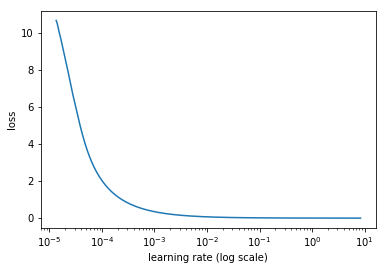

In [102]:
learner.sched.plot()

In [93]:
??learner.crit

In [94]:
lrs=np.array([1.0e-4,1.0e-3,1.0e-2])
learner.freeze_to(-2)
learner.fit(lrs/2, 1)
learner.unfreeze()
learner.fit(lrs, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      16.431645  14.061416 



A Jupyter Widget

epoch      trn_loss   val_loss                               
    0      0.65052    0.062206  



[0.062205672]

In [84]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='mercari')

A Jupyter Widget

epoch      trn_loss   val_loss                               
    0      0.143078   0.030417  
    1      0.141826   0.031732                               
    2      0.13973    0.031122                               
    3      0.141468   0.033243                               
    4      0.13998    0.031004                               
    5      0.139549   0.029887                               
    6      0.140449   0.029943                               



[0.029943017]

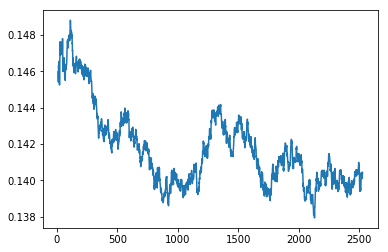

In [85]:
learner.sched.plot_loss()

# Learner and Model

In [24]:
dep = 'price'
test[dep] = 0
joined = train[cat_vars+contin_vars+[dep,'name']].copy()
joined_test = test[cat_vars+contin_vars+[dep, 'name',  'test_id']].copy()

In [25]:
cat_vars+contin_vars+[dep,'name']

['cat1',
 'cat2',
 'cat3',
 'brand_name',
 'shipping',
 'item_condition_id',
 'price',
 'name']

In [26]:
######## NYI
# factors the individual columns (does not make sense for item_description need NLP??)
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [27]:
apply_cats(joined_test, joined)

In [28]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [29]:
#joined['item_condition_id'] = joined.item_condition_id.astype(np.int32)
#joined['shipping'] = joined.shipping.astype(np.int32)
#joined_test['item_condition_id'] = joined_test.item_condition_id.astype(np.int32)
#joined_test['shipping'] = joined_test.shipping.astype(np.int32)

In [30]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=0.2)
joined_samp = joined.iloc[idxs].set_index("name")
samp_size = len(joined_samp); samp_size

296507

In [31]:
#n = len(joined)
#samp_size = n
#joined_samp = joined

In [32]:
joined_samp.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id,price
name,,,,,,,
F/ship 4 Totoro Washi + 1 pen,Handmade,Paper Goods,Stationery,NaN,1,1.0,12.0
UCLA Men's Bundle + Shorts,Women,Other,Other,Adidas,1,1.0,76.0
Listing for lol,Beauty,Makeup,Lips,NaN,1,1.0,12.0
25 pcs kawaii sticker flakes,Kids,Toys,Arts & Crafts,NaN,1,1.0,3.0
Chanel Mini Lipgloss Set,Beauty,Makeup,Lips,Chanel,1,2.0,30.0


In [33]:
#??proc_df

In [34]:
len(joined_samp)

296507

In [35]:
joined_test = joined_test

In [36]:
joined_test = joined_test.set_index("name")
joined = joined.set_index("name")

In [37]:
df, y, nas, mapper = proc_df(joined, 'price', do_scale=True)
yl = np.log(y+1).astype('float32')

In [38]:
df_test, _, nas, mapper = proc_df(joined_test, 'price', do_scale=True, skip_flds=['test_id'],
                                  mapper=mapper, na_dict=nas)
#for n,c in joined_samp.items(): print(n), print(c)

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [40]:
val_idx[1:5]

[222381, 222382, 222383, 222384]

In [41]:
df.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id
name,,,,,,
MLB Cincinnati Reds T Shirt Size XL,6,104,764,0,2,1.209777
Razer BlackWidow Chroma Keyboard,2,31,213,3558,1,1.209777
AVA-VIV Blouse,10,105,95,4181,2,-1.004675
Leather Horse Statues,4,56,405,0,2,-1.004675
24K GOLD plated rose,10,59,538,0,1,-1.004675


In [42]:
len(joined)

1482535

In [43]:
def exp_rmsle(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [44]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [45]:
yl.dtype

dtype('float32')

In [46]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [47]:
cat_sz

[('cat1', 12),
 ('cat2', 115),
 ('cat3', 872),
 ('brand_name', 4810),
 ('shipping', 3)]

In [48]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [49]:
emb_szs

[(12, 6), (115, 50), (872, 50), (4810, 50), (3, 2)]

In [50]:
df.columns

Index(['cat1', 'cat2', 'cat3', 'brand_name', 'shipping', 'item_condition_id'], dtype='object')

In [51]:
cat_vars

['cat1', 'cat2', 'cat3', 'brand_name', 'shipping']

In [52]:
y_range

(0, 9.1270677566528313)

In [53]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1500,1000,500], [0.001,0.01,0.01], y_range=y_range)
lr = 1e-3

In [54]:
m.lr_find()

A Jupyter Widget

 61%|██████▏   | 1068/1738 [00:09<00:05, 114.63it/s, loss=1.72] 


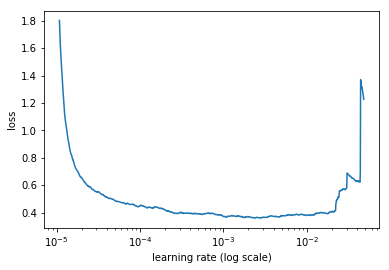

In [55]:
m.sched.plot()

In [56]:
lr=5.0e-5
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.36065  0.35247  0.59251]                           
[ 1.       0.334    0.32686  0.57049]                           
[ 2.       0.3201   0.32173  0.56601]                           
[ 3.       0.31909  0.32209  0.56627]                           
[ 4.       0.31596  0.31786  0.56258]                           
[ 5.       0.29835  0.31438  0.55947]                           
[ 6.       0.30538  0.31377  0.55894]                           



In [48]:
lr = 5.0e-4
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=2)

A Jupyter Widget

[ 0.       0.32404  0.31878  0.56345]                           
[ 1.       0.30513  0.31197  0.55732]                           
[ 2.       0.29919  0.31445  0.55954]                           
[ 3.       0.28376  0.31089  0.55636]                           
[ 4.       0.30098  0.3125   0.55779]                           
[ 5.       0.28833  0.31059  0.55608]                           



In [47]:
??md.get_learner